 __Project - Wine classification__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Feature engineering](#Feature-engineering)
        1. [Handcrafted](#Handcrafted)
        1. [Polynomial features](#Polynomial-features)
    1. [Feature transformation](#Feature-transformation)
        1. [Skew correction](#Skew-correction)
        1. [Scaling](#Scaling)     
    1. [Outliers](#Outliers)
    1. [Additional exploratory data analysis](#Additional-exploratory-data-analysis)
1. [Feature importance](#Feature-importance)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Validation set evaluation - standard models](#Validation-set-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Validation set evaluation - stacked models](#Validation-set-evaluation-stacked-models)


# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import copy
import os
import sys
import importlib
import itertools
from functools import reduce
import time

rundate = time.strftime("%Y%m%d")

import warnings

warnings.simplefilter("ignore")

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.datasets import (
    load_boston,
    load_wine,
    load_iris,
    load_breast_cancer,
    make_blobs,
    make_moons,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    IsolationForest,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    Lasso,
    Ridge,
    ElasticNet,
    LinearRegression,
    LogisticRegression,
    SGDRegressor,
)
from sklearn.model_selection import (
    KFold,
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
    QuantileTransformer,
    PowerTransformer,
    MinMaxScaler,
)
from sklearn.svm import SVC, SVR
from category_encoders import (
    WOEEncoder,
    TargetEncoder,
    CatBoostEncoder,
    BinaryEncoder,
    CountEncoder,
)

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from hyperopt import hp

import eif
import shap

shap.initjs()

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import squarify

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    import mlmachine.data as data
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasTransformer,
        KFoldSelectEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

## Data

<a id = 'Data'></a>

In [2]:
# load and inspect data
dataset = load_wine()
dataset = pd.merge(pd.DataFrame(dataset.data, columns=dataset.feature_names), pd.Series(dataset.target, name="Class label"), left_index=True, right_index=True)

print("Training data dimensions: {}".format(dataset.shape))

Training data dimensions: (178, 14)


In [3]:
# display info and first 5 rows
dataset.info()
display(dataset[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Class

alcohol  malic_acid      ash  alcalinity_of_ash  magnesium  total_phenols  \
0 14.230000    1.710000 2.430000          15.600000 127.000000       2.800000   
1 13.200000    1.780000 2.140000          11.200000 100.000000       2.650000   
2 13.160000    2.360000 2.670000          18.600000 101.000000       2.800000   
3 14.370000    1.950000 2.500000          16.800000 113.000000       3.850000   
4 13.240000    2.590000 2.870000          21.000000 118.000000       2.800000   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity  \
0    3.060000              0.280000         2.290000         5.640000   
1    2.760000              0.260000         1.280000         4.380000   
2    3.240000              0.300000         2.810000         5.680000   
3    3.490000              0.240000         2.180000         7.800000   
4    2.690000              0.390000         1.820000         4.320000   

       hue  od280/od315_of_diluted_wines      proline  Class label  
0 1.040000                      3.920000 1,065.000000            0  
1 1.050000                      3.400000 1,050.000000            0  
2 1.030000                      3.170000 1,185.000000            0  
3 0.860000                      3.450000 1,480.000000            0  
4 1.040000                      2.930000   735.000000            0

In [4]:
# review counts of different column types
dataset.dtypes.value_counts()

float64    13
int64       1
dtype: int64

In [5]:
# split dataset into train and validation datasets
df_train, df_valid = mlm.train_test_df_compile(data=dataset, target_col='Class label')

In [6]:
# Load training data into mlmachine
train = mlm.Machine(
    data=df_train,
    identify_as_continuous=['magnesium', 'proline'],
    target="Class label",
    is_classification=True,
)

>>> category label encoding

	0 --> 0
	1 --> 1
	2 --> 2



In [7]:
# Load test data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    identify_as_continuous=['magnesium', 'proline'],
    is_classification=True,
)

# EDA

<a id = 'EDA'></a>

## Continuous feature EDA

<a id = 'Continuous-feature-EDA'></a>

Feature summary Feature vs. target summary 
 
 
 
 alcalinity_of_ash 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 19.676056 
 
 
 std 
 3.400541 
 
 
 min 
 10.600000 
 
 
 25% 
 17.250000 
 
 
 50% 
 19.500000 
 
 
 75% 
 21.575000 
 
 
 max 
 30.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.218650 
 
 
 kurtosis 
 0.463017 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 17.263830 
 2.577350 
 
 
 1 
 57.000000 
 40.140845 
 20.519298 
 3.486638 
 
 
 2 
 38.000000 
 26.760563 
 21.394737 
 2.288869

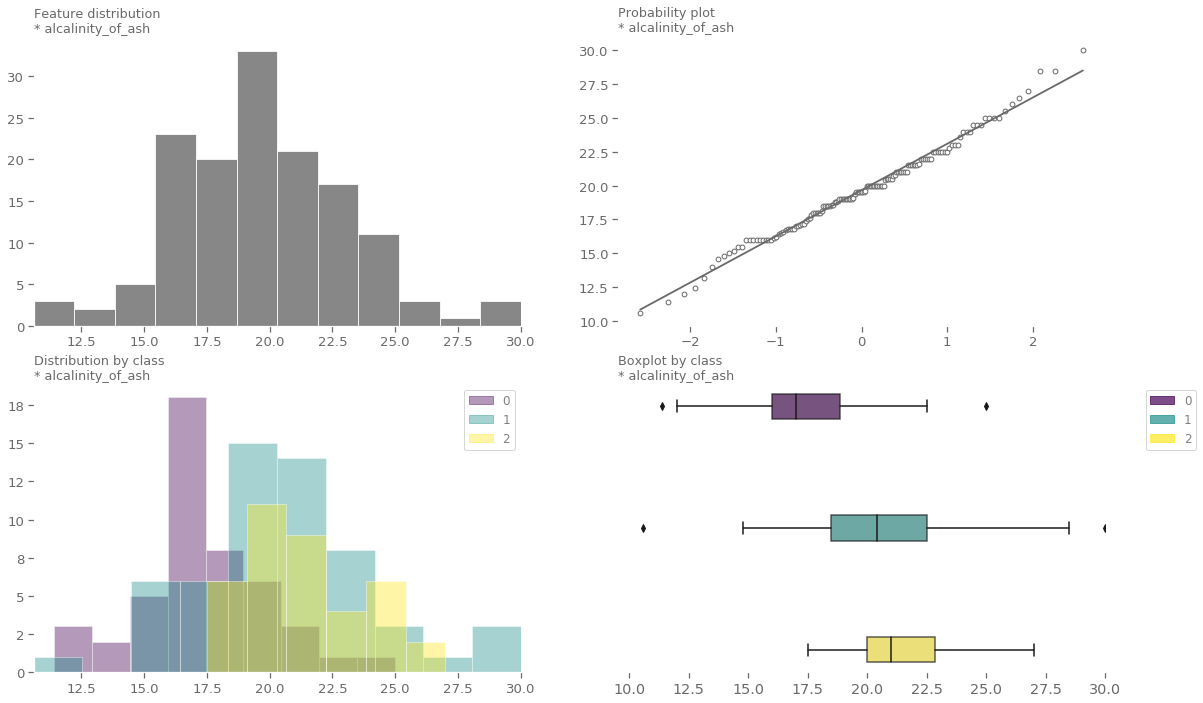

Feature summary Feature vs. target summary 
 
 
 
 alcohol 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 12.960493 
 
 
 std 
 0.814532 
 
 
 min 
 11.030000 
 
 
 25% 
 12.330000 
 
 
 50% 
 13.040000 
 
 
 75% 
 13.635000 
 
 
 max 
 14.750000 
 
 
 missing 
 0.000000 
 
 
 skew 
 -0.094670 
 
 
 kurtosis 
 -0.916258 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 13.708723 
 0.436849 
 
 
 1 
 57.000000 
 40.140845 
 12.210877 
 0.509851 
 
 
 2 
 38.000000 
 26.760563 
 13.159474 
 0.510799

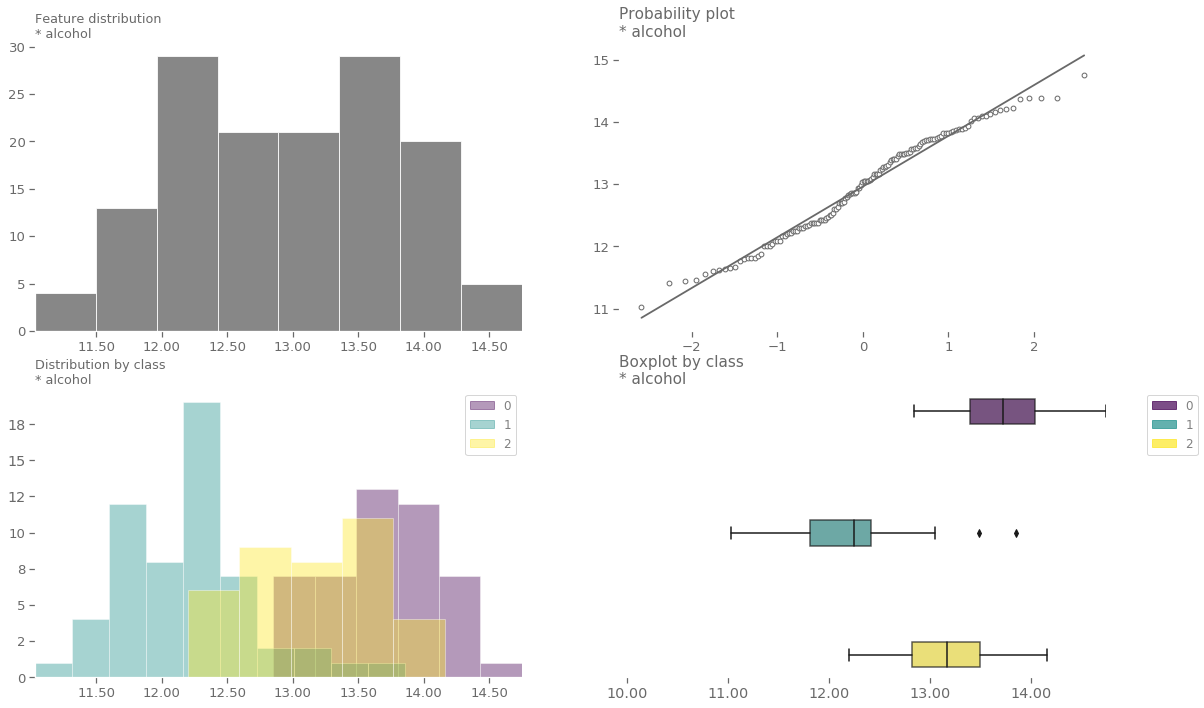

Feature summary Feature vs. target summary 
 
 
 
 ash 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 2.381620 
 
 
 std 
 0.281109 
 
 
 min 
 1.360000 
 
 
 25% 
 2.230000 
 
 
 50% 
 2.375000 
 
 
 75% 
 2.597500 
 
 
 max 
 3.230000 
 
 
 missing 
 0.000000 
 
 
 skew 
 -0.174960 
 
 
 kurtosis 
 1.080960 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 2.470851 
 0.233164 
 
 
 1 
 57.000000 
 40.140845 
 2.264737 
 0.324362 
 
 
 2 
 38.000000 
 26.760563 
 2.446579 
 0.183293

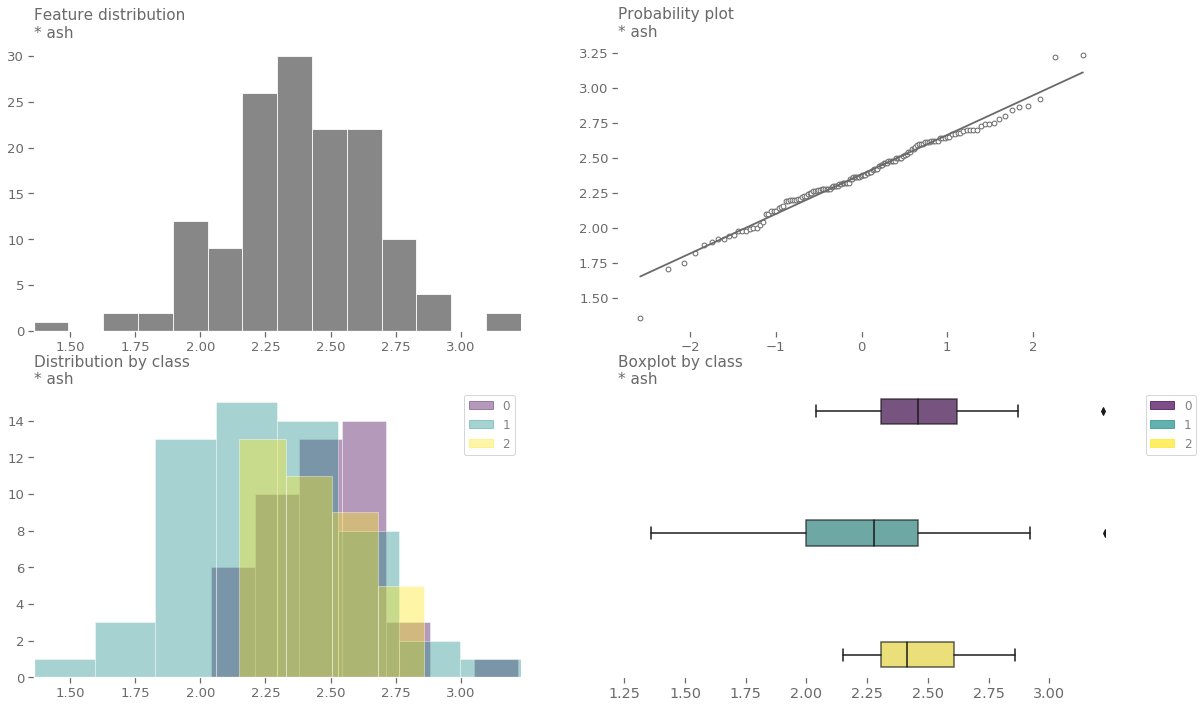

Feature summary Feature vs. target summary 
 
 
 
 color_intensity 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 5.003310 
 
 
 std 
 2.291925 
 
 
 min 
 1.280000 
 
 
 25% 
 3.122500 
 
 
 50% 
 4.640000 
 
 
 75% 
 6.122500 
 
 
 max 
 11.750000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.799580 
 
 
 kurtosis 
 0.018495 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 5.487021 
 1.267462 
 
 
 1 
 57.000000 
 40.140845 
 3.060351 
 0.923021 
 
 
 2 
 38.000000 
 26.760563 
 7.319474 
 2.215753

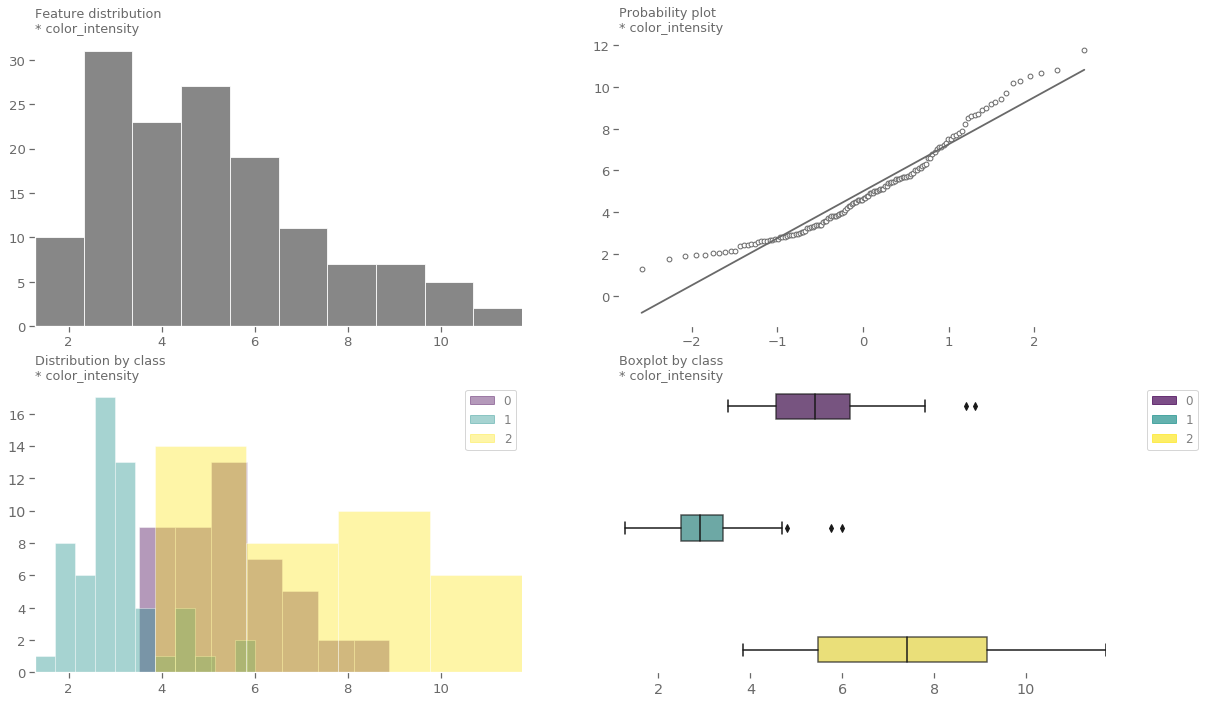

Feature summary Feature vs. target summary 
 
 
 
 flavanoids 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 2.007958 
 
 
 std 
 1.012108 
 
 
 min 
 0.340000 
 
 
 25% 
 1.125000 
 
 
 50% 
 2.035000 
 
 
 75% 
 2.842500 
 
 
 max 
 5.080000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.109660 
 
 
 kurtosis 
 -0.814813 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 3.006809 
 0.414421 
 
 
 1 
 57.000000 
 40.140845 
 2.010351 
 0.699353 
 
 
 2 
 38.000000 
 26.760563 
 0.768947 
 0.292753

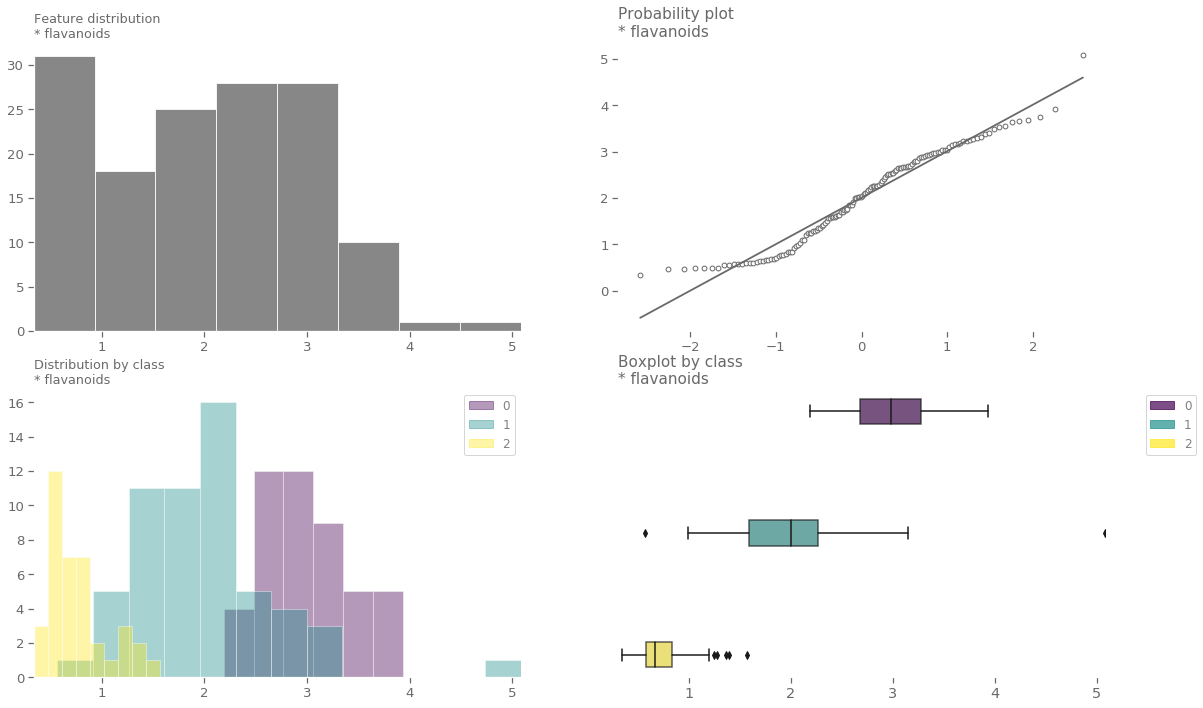

Feature summary Feature vs. target summary 
 
 
 
 hue 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 0.958282 
 
 
 std 
 0.225256 
 
 
 min 
 0.480000 
 
 
 25% 
 0.792500 
 
 
 50% 
 0.960000 
 
 
 75% 
 1.117500 
 
 
 max 
 1.710000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.083970 
 
 
 kurtosis 
 -0.164794 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 1.061277 
 0.116630 
 
 
 1 
 57.000000 
 40.140845 
 1.051333 
 0.201644 
 
 
 2 
 38.000000 
 26.760563 
 0.691316 
 0.114367

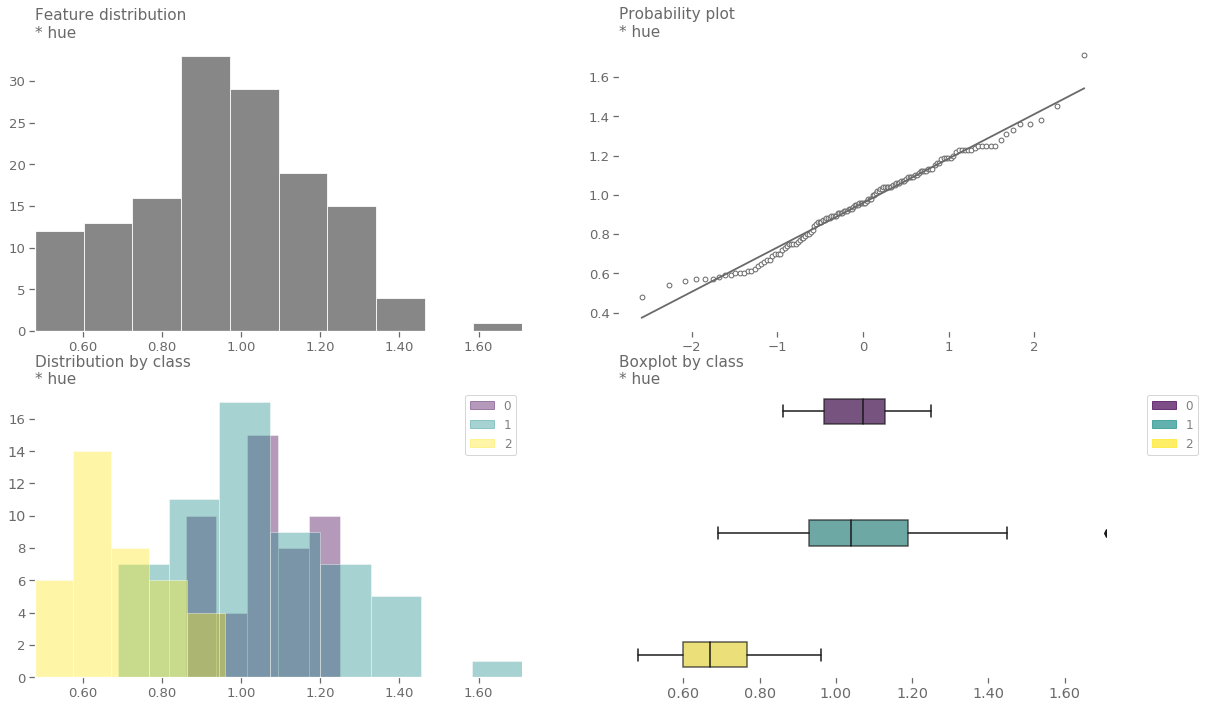

Feature summary Feature vs. target summary 
 
 
 
 magnesium 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 100.359155 
 
 
 std 
 14.924083 
 
 
 min 
 70.000000 
 
 
 25% 
 88.000000 
 
 
 50% 
 98.000000 
 
 
 75% 
 108.000000 
 
 
 max 
 162.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 1.077310 
 
 
 kurtosis 
 1.866857 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 106.489362 
 10.181068 
 
 
 1 
 57.000000 
 40.140845 
 95.456140 
 17.957132 
 
 
 2 
 38.000000 
 26.760563 
 100.131579 
 11.487226

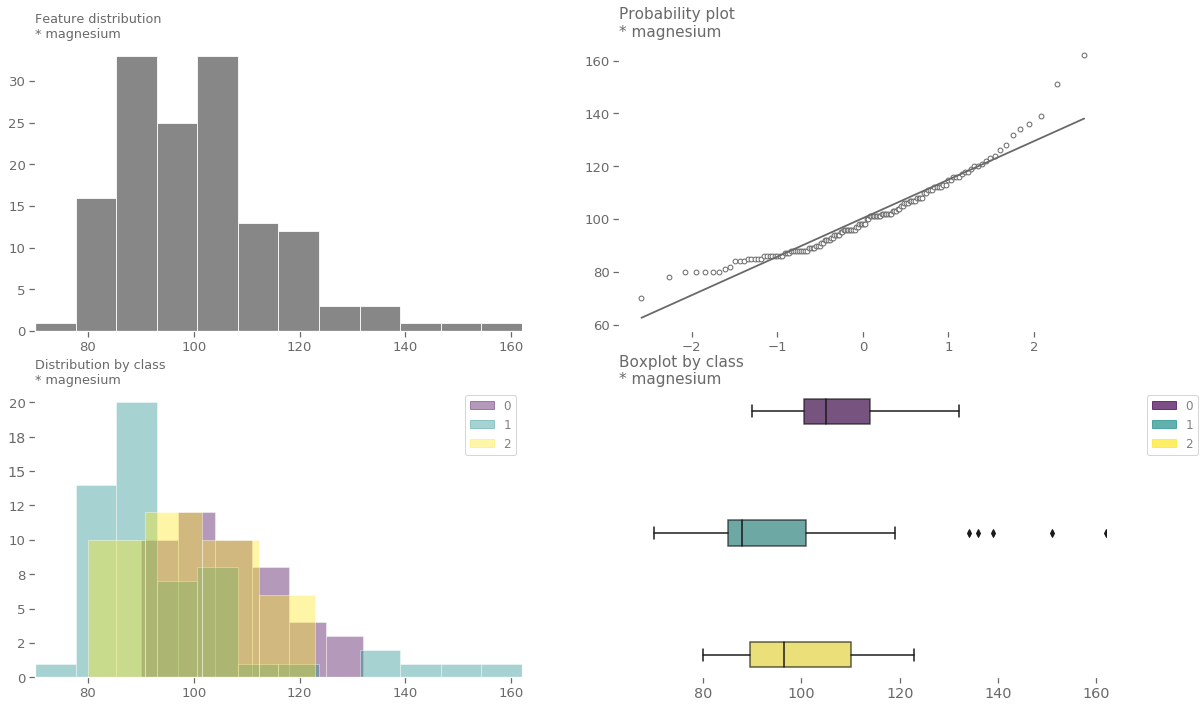

Feature summary Feature vs. target summary 
 
 
 
 malic_acid 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 2.397465 
 
 
 std 
 1.127104 
 
 
 min 
 0.740000 
 
 
 25% 
 1.610000 
 
 
 50% 
 1.885000 
 
 
 75% 
 3.225000 
 
 
 max 
 5.650000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.947320 
 
 
 kurtosis 
 -0.099148 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 2.045106 
 0.686464 
 
 
 1 
 57.000000 
 40.140845 
 1.954561 
 0.926702 
 
 
 2 
 38.000000 
 26.760563 
 3.497632 
 1.088365

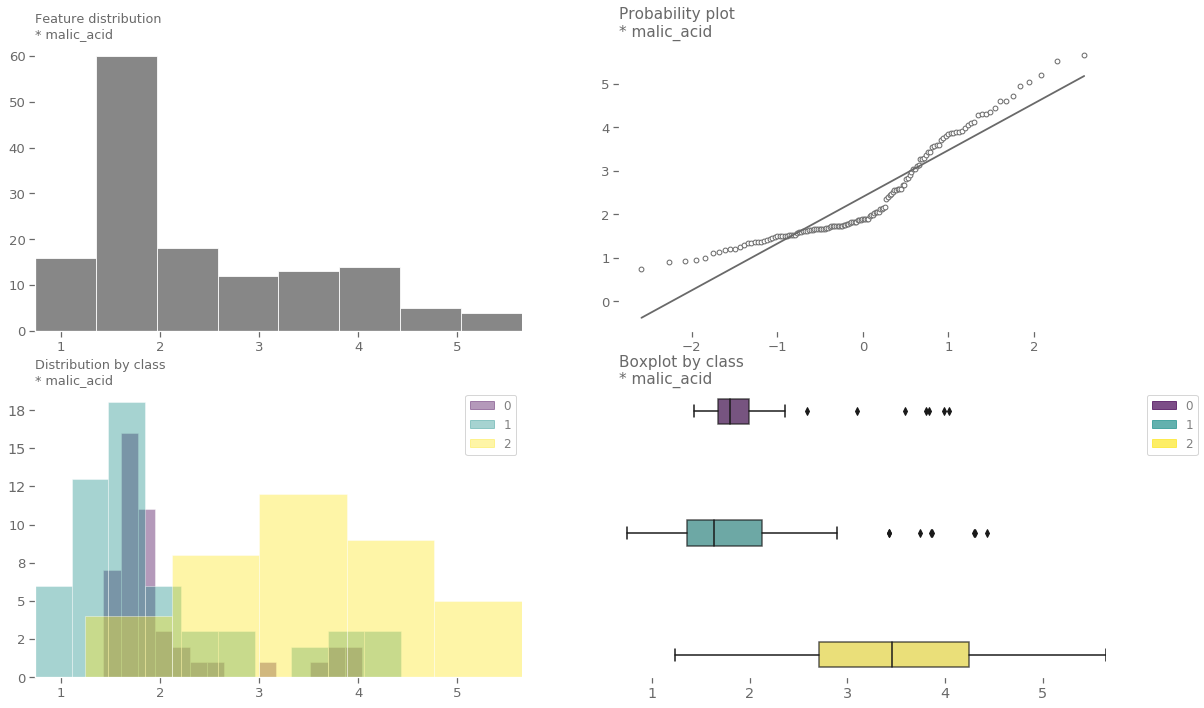

Feature summary Feature vs. target summary 
 
 
 
 nonflavanoid_phenols 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 0.368592 
 
 
 std 
 0.128458 
 
 
 min 
 0.140000 
 
 
 25% 
 0.270000 
 
 
 50% 
 0.345000 
 
 
 75% 
 0.447500 
 
 
 max 
 0.660000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.378160 
 
 
 kurtosis 
 -0.734131 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 0.290851 
 0.076041 
 
 
 1 
 57.000000 
 40.140845 
 0.377193 
 0.124122 
 
 
 2 
 38.000000 
 26.760563 
 0.451842 
 0.128265

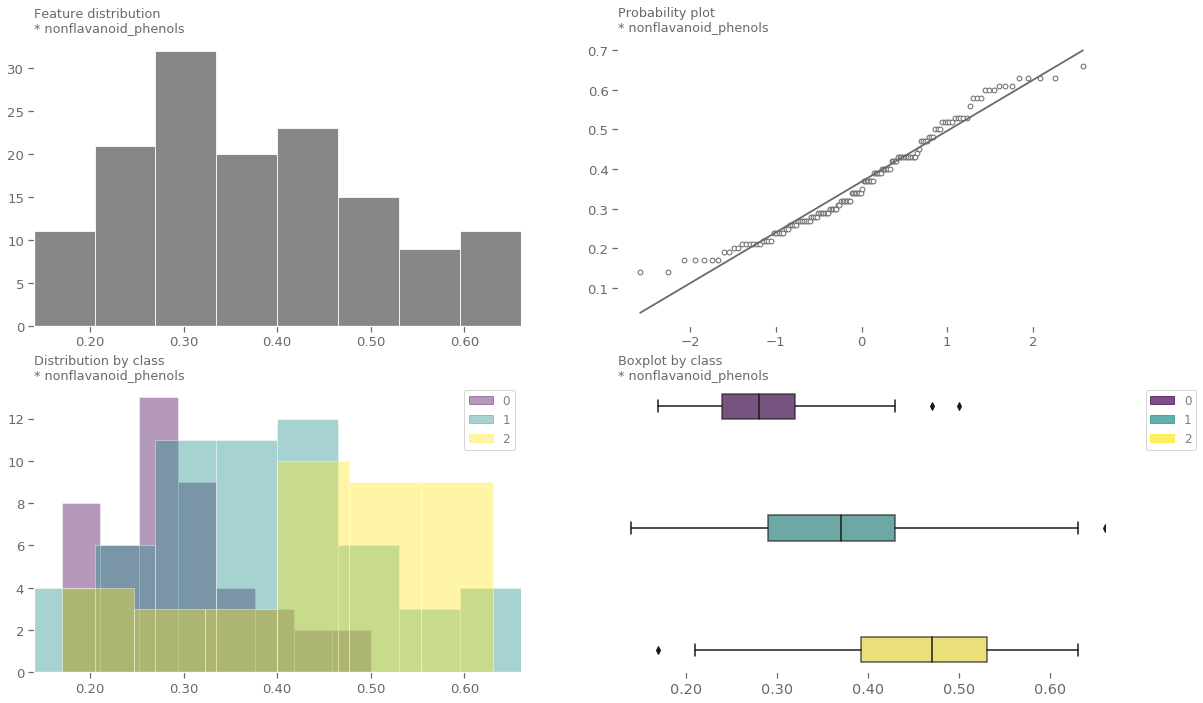

Feature summary Feature vs. target summary 
 
 
 
 od280/od315_of_diluted_wines 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 2.613451 
 
 
 std 
 0.718471 
 
 
 min 
 1.270000 
 
 
 25% 
 1.940000 
 
 
 50% 
 2.775000 
 
 
 75% 
 3.200000 
 
 
 max 
 4.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 -0.283980 
 
 
 kurtosis 
 -1.125408 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 3.184468 
 0.338820 
 
 
 1 
 57.000000 
 40.140845 
 2.758596 
 0.519353 
 
 
 2 
 38.000000 
 26.760563 
 1.689474 
 0.283149

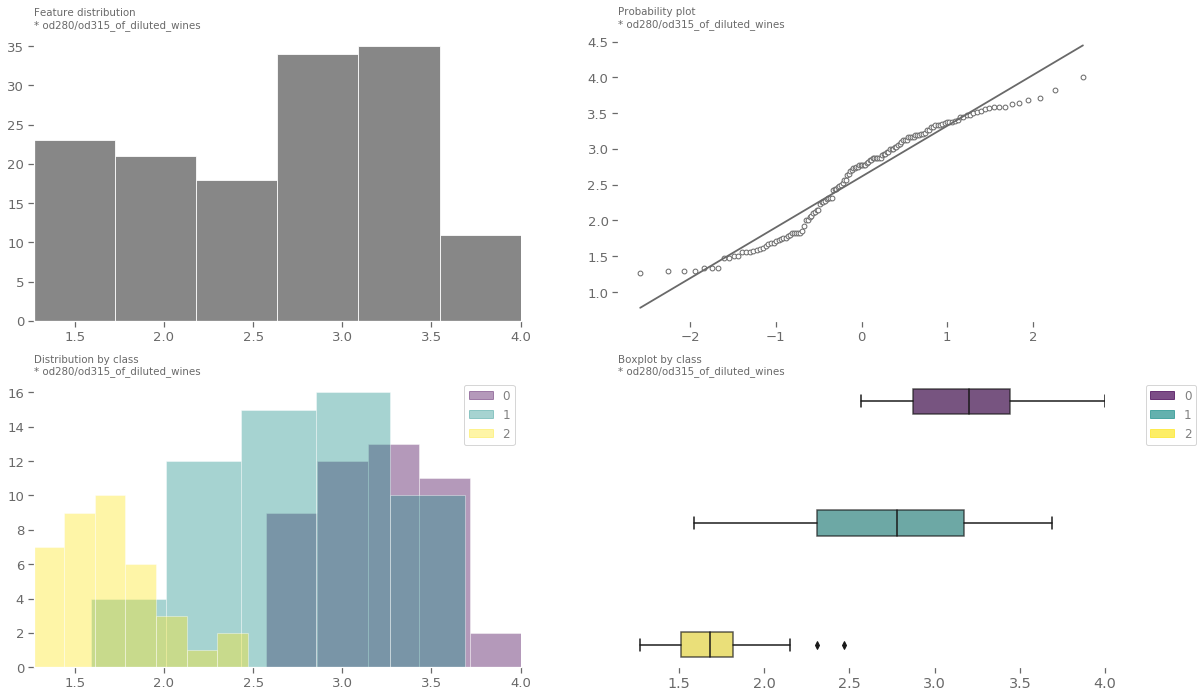

Feature summary Feature vs. target summary 
 
 
 
 proanthocyanins 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 1.604648 
 
 
 std 
 0.569526 
 
 
 min 
 0.410000 
 
 
 25% 
 1.250000 
 
 
 50% 
 1.560000 
 
 
 75% 
 1.942500 
 
 
 max 
 3.580000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.627570 
 
 
 kurtosis 
 0.739485 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 1.930851 
 0.429095 
 
 
 1 
 57.000000 
 40.140845 
 1.630702 
 0.594102 
 
 
 2 
 38.000000 
 26.760563 
 1.162105 
 0.343375

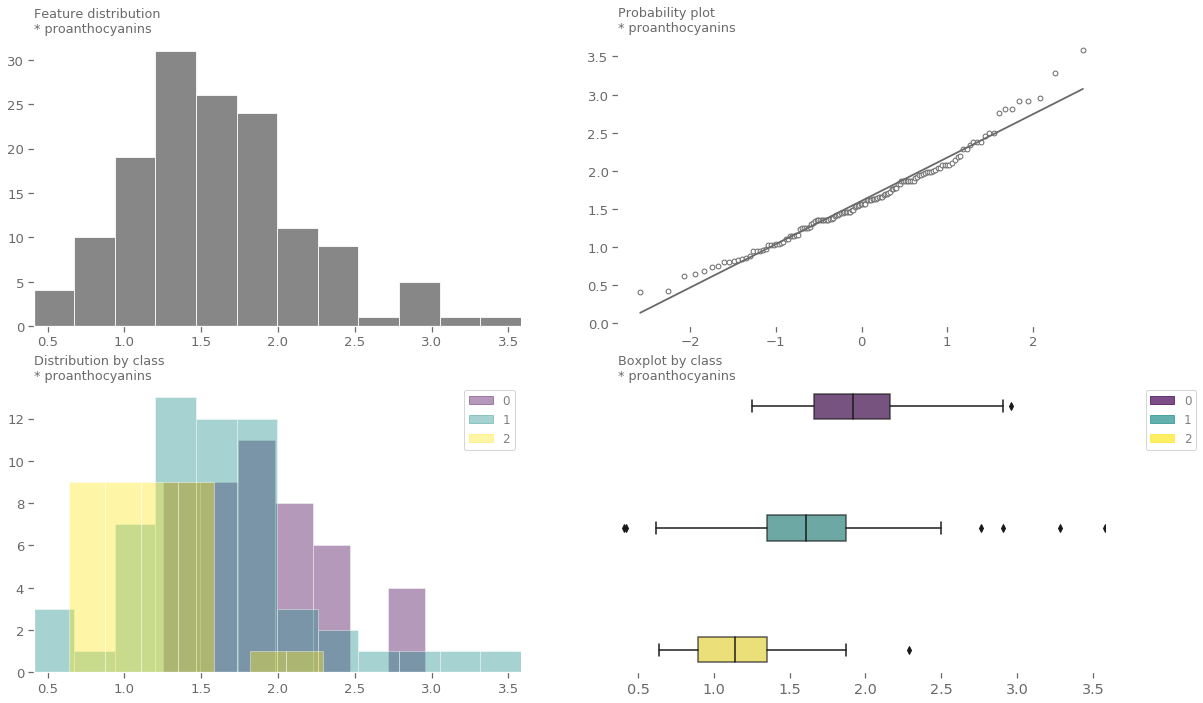

Feature summary Feature vs. target summary 
 
 
 
 proline 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 743.422535 
 
 
 std 
 316.849436 
 
 
 min 
 278.000000 
 
 
 25% 
 495.000000 
 
 
 50% 
 676.500000 
 
 
 75% 
 973.000000 
 
 
 max 
 1,680.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.781210 
 
 
 kurtosis 
 -0.176440 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 1,111.212766 
 224.646288 
 
 
 1 
 57.000000 
 40.140845 
 507.789474 
 152.245962 
 
 
 2 
 38.000000 
 26.760563 
 641.973684 
 120.178264

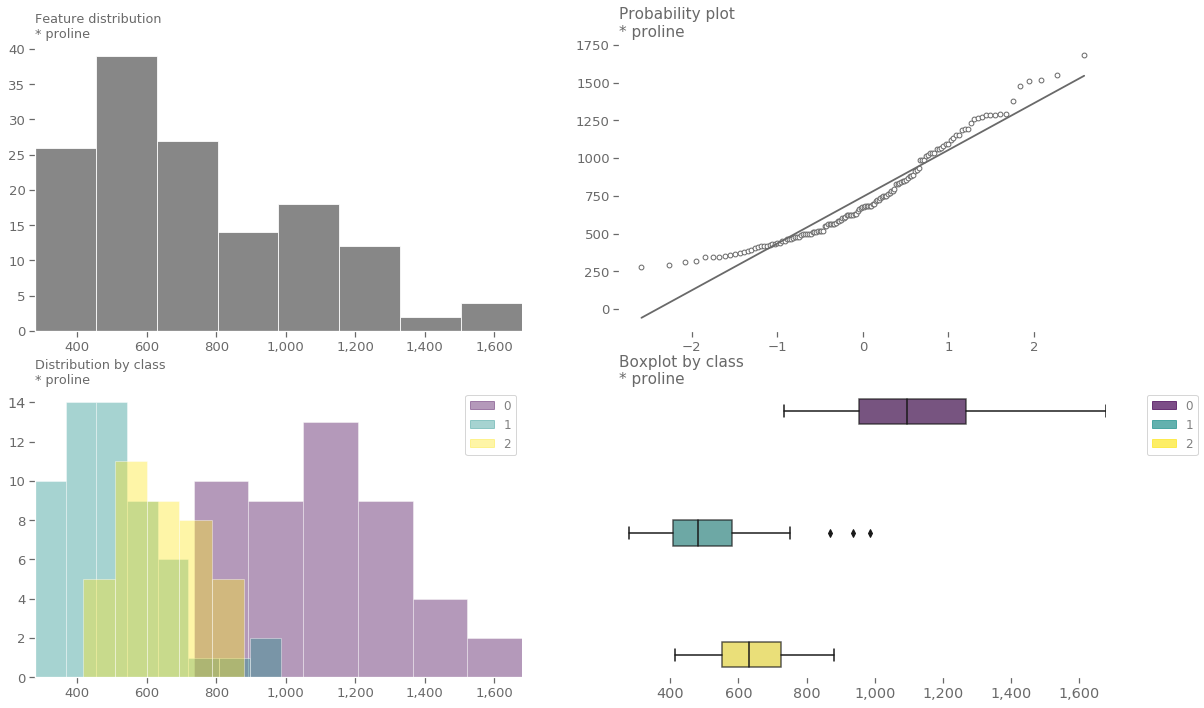

Feature summary Feature vs. target summary 
 
 
 
 total_phenols 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 2.272465 
 
 
 std 
 0.625713 
 
 
 min 
 0.980000 
 
 
 25% 
 1.705000 
 
 
 50% 
 2.270000 
 
 
 75% 
 2.787500 
 
 
 max 
 3.880000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.198520 
 
 
 kurtosis 
 -0.817705 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 2.858085 
 0.345615 
 
 
 1 
 57.000000 
 40.140845 
 2.182807 
 0.534168 
 
 
 2 
 38.000000 
 26.760563 
 1.682632 
 0.304715

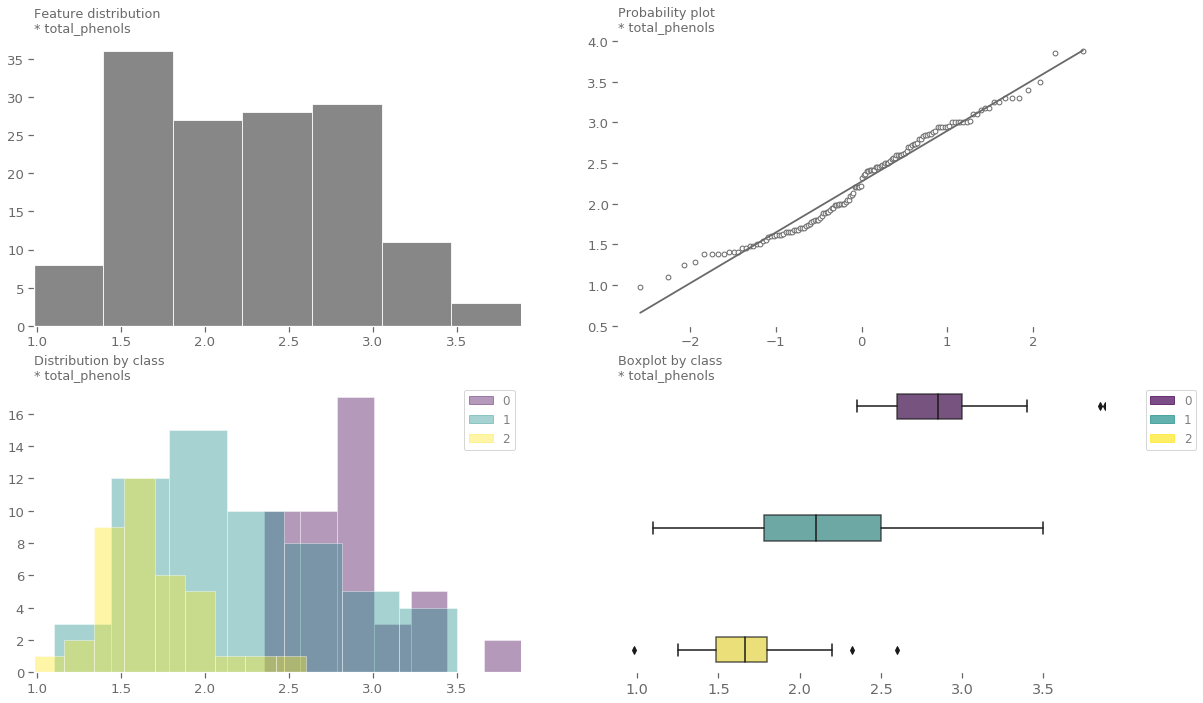

In [8]:
# continuous features
for feature in train.data.mlm_dtypes["continuous"]:
    train.eda_cat_target_num_feat(
        feature=feature,
        outliers_out_of_scope=5,
        chart_scale=12
    )

Feature summary Feature vs. target summary 
 
 
 
 alcalinity_of_ash 
 
 
 
 
 count 
 142.000000 
 
 
 mean 
 19.676056 
 
 
 std 
 3.400541 
 
 
 min 
 10.600000 
 
 
 25% 
 17.250000 
 
 
 50% 
 19.500000 
 
 
 75% 
 21.575000 
 
 
 max 
 30.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.218650 
 
 
 kurtosis 
 0.463017 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 0 
 47.000000 
 33.098592 
 17.263830 
 2.577350 
 
 
 1 
 57.000000 
 40.140845 
 20.519298 
 3.486638 
 
 
 2 
 38.000000 
 26.760563 
 21.394737 
 2.288869

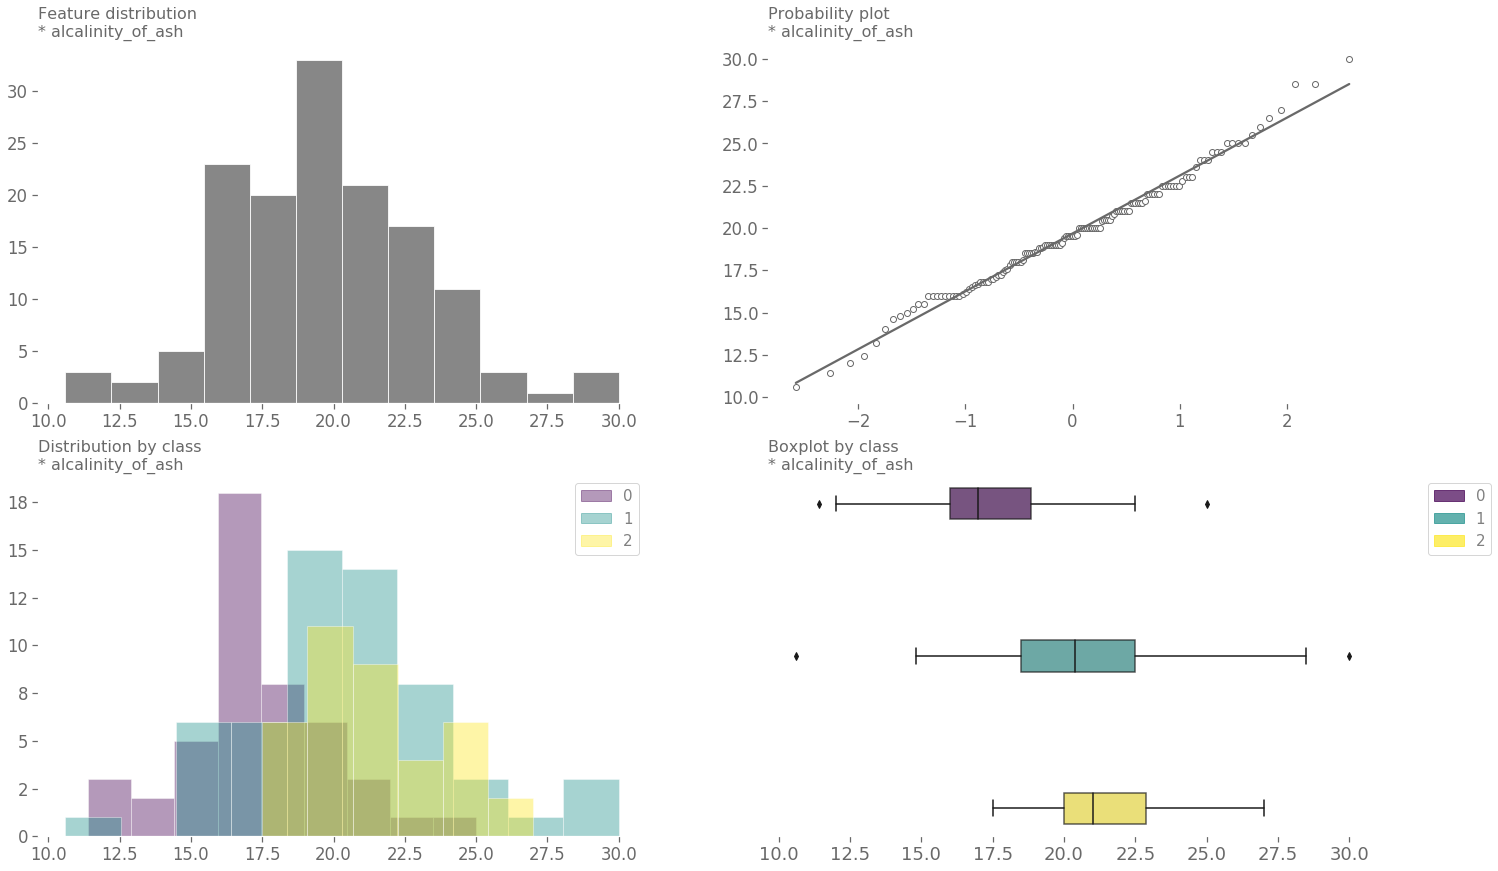

In [9]:
train.eda_cat_target_num_feat(
    feature="alcalinity_of_ash",
)

##### Correlation

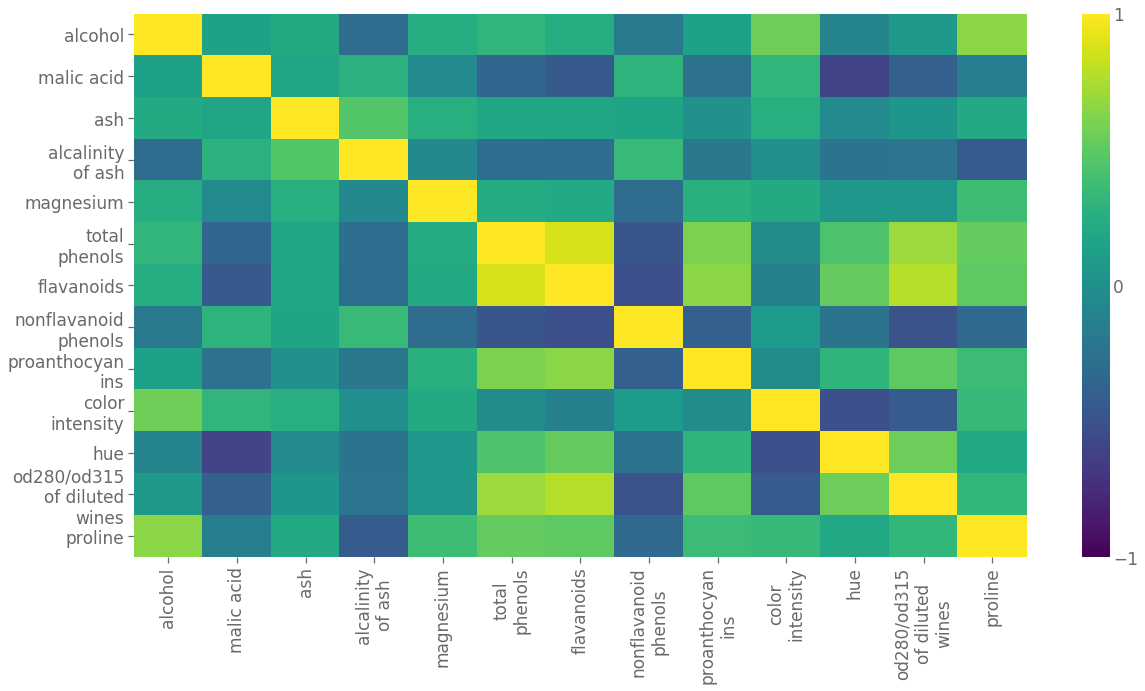

In [10]:
# correlation heat map
p = PrettierPlot(chart_scale=20)
ax = p.make_canvas()
p.corr_heatmap(df=train.data, annot=False, ax=ax)

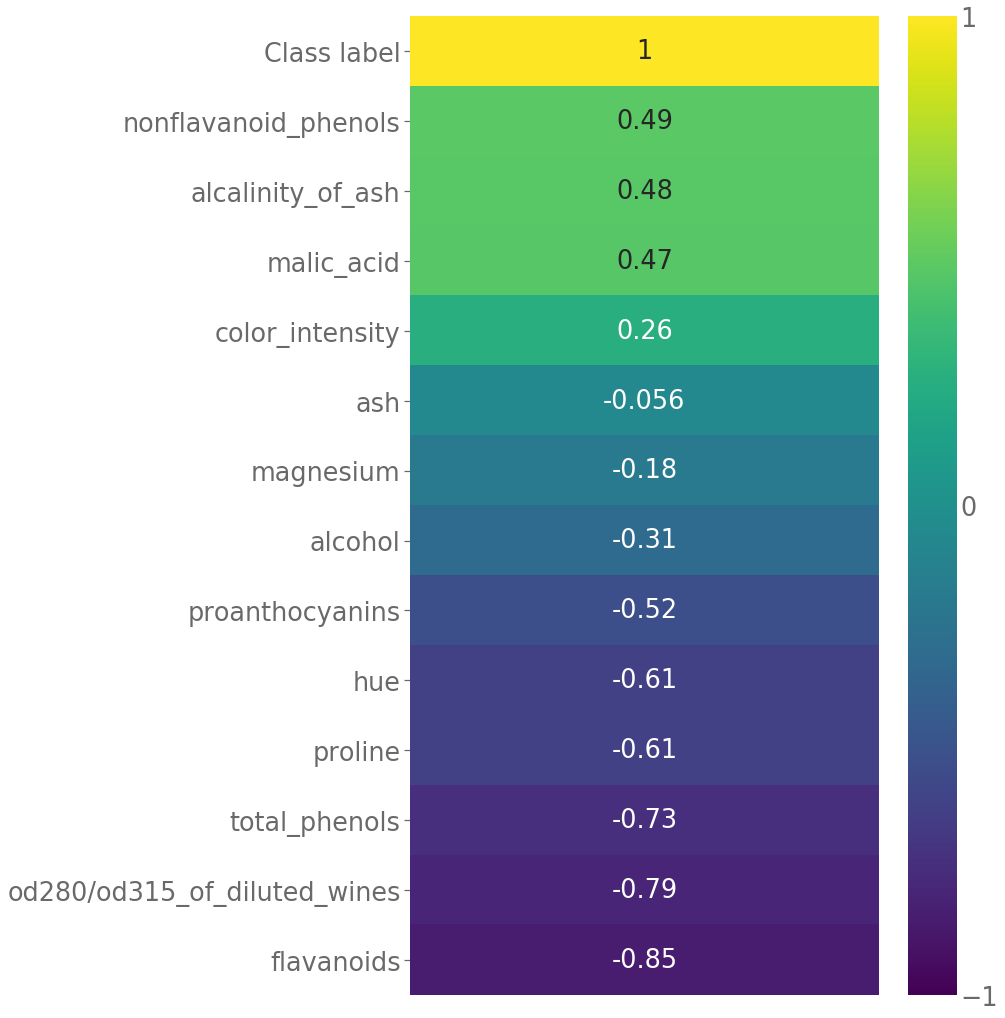

In [11]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall')
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data, target=train.target, thresh=0.02, annot=True, ax=ax
)

##### Pair plot

<Figure size 864x432 with 0 Axes>

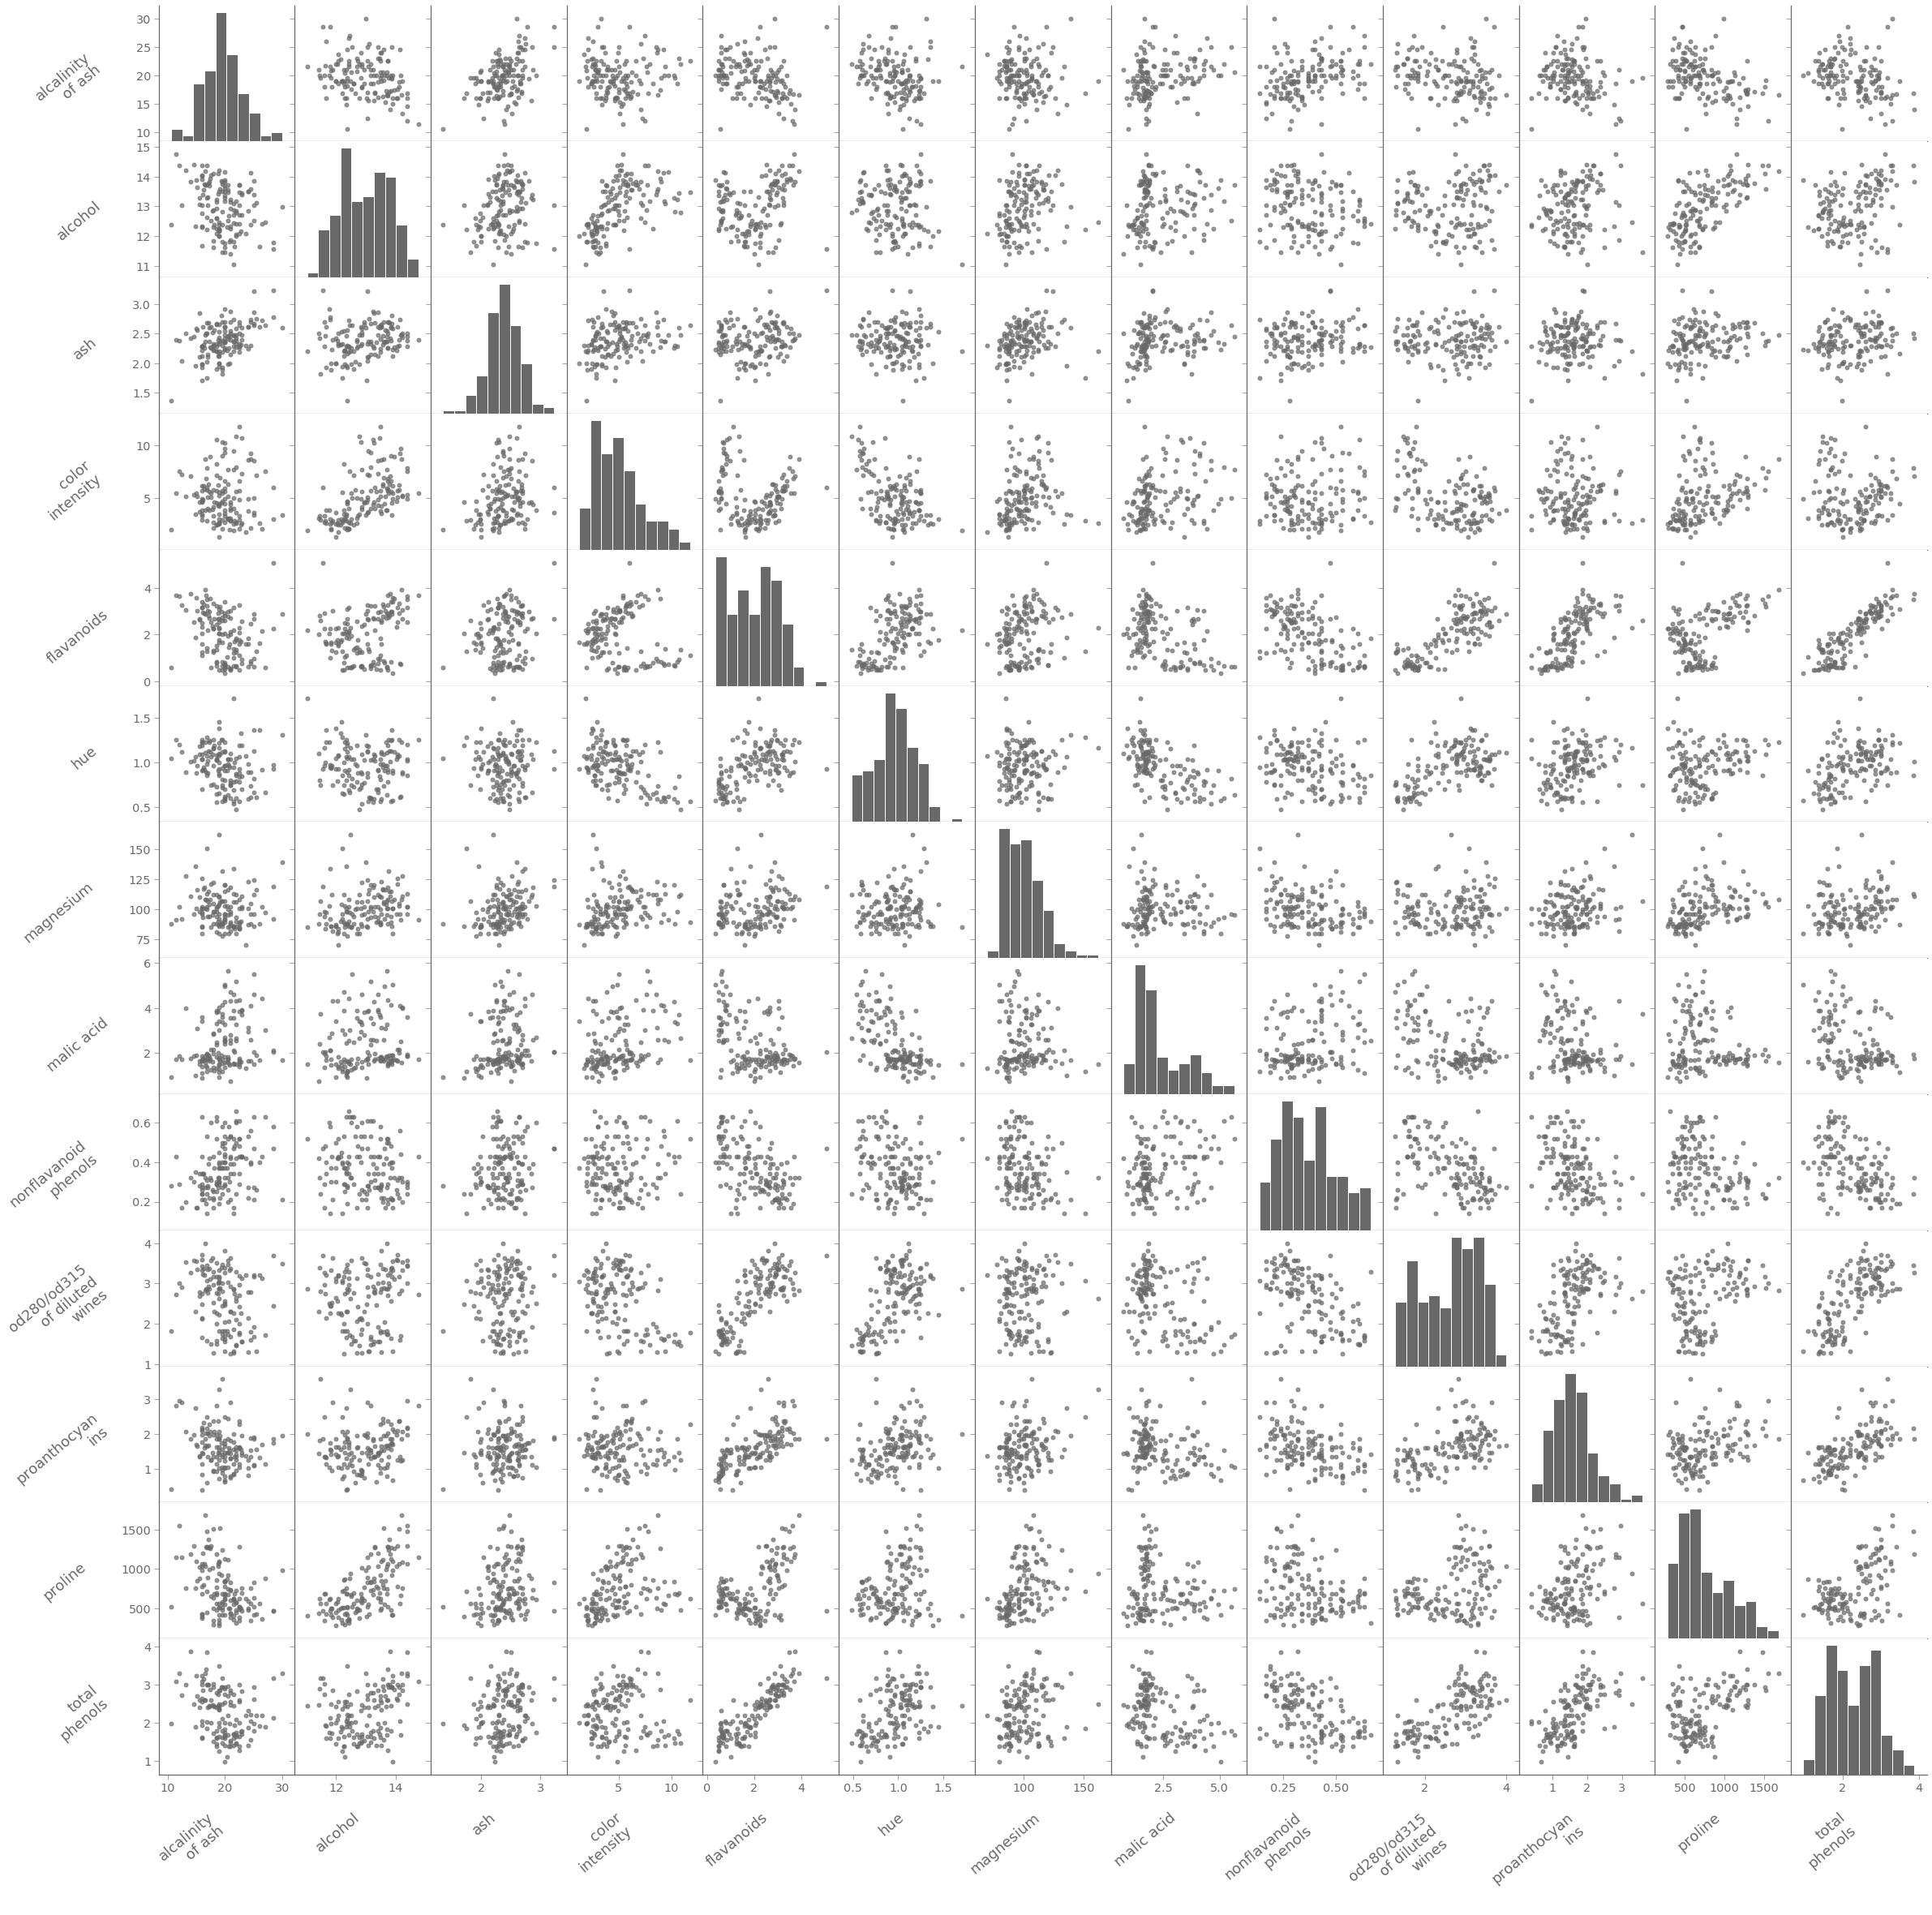

In [12]:
# pair plot
p = PrettierPlot(chart_scale=12)
p.pair_plot(
    df=train.data,
    columns=train.data.mlm_dtypes['continuous'],
    diag_kind="auto",
)

<Figure size 864x432 with 0 Axes>

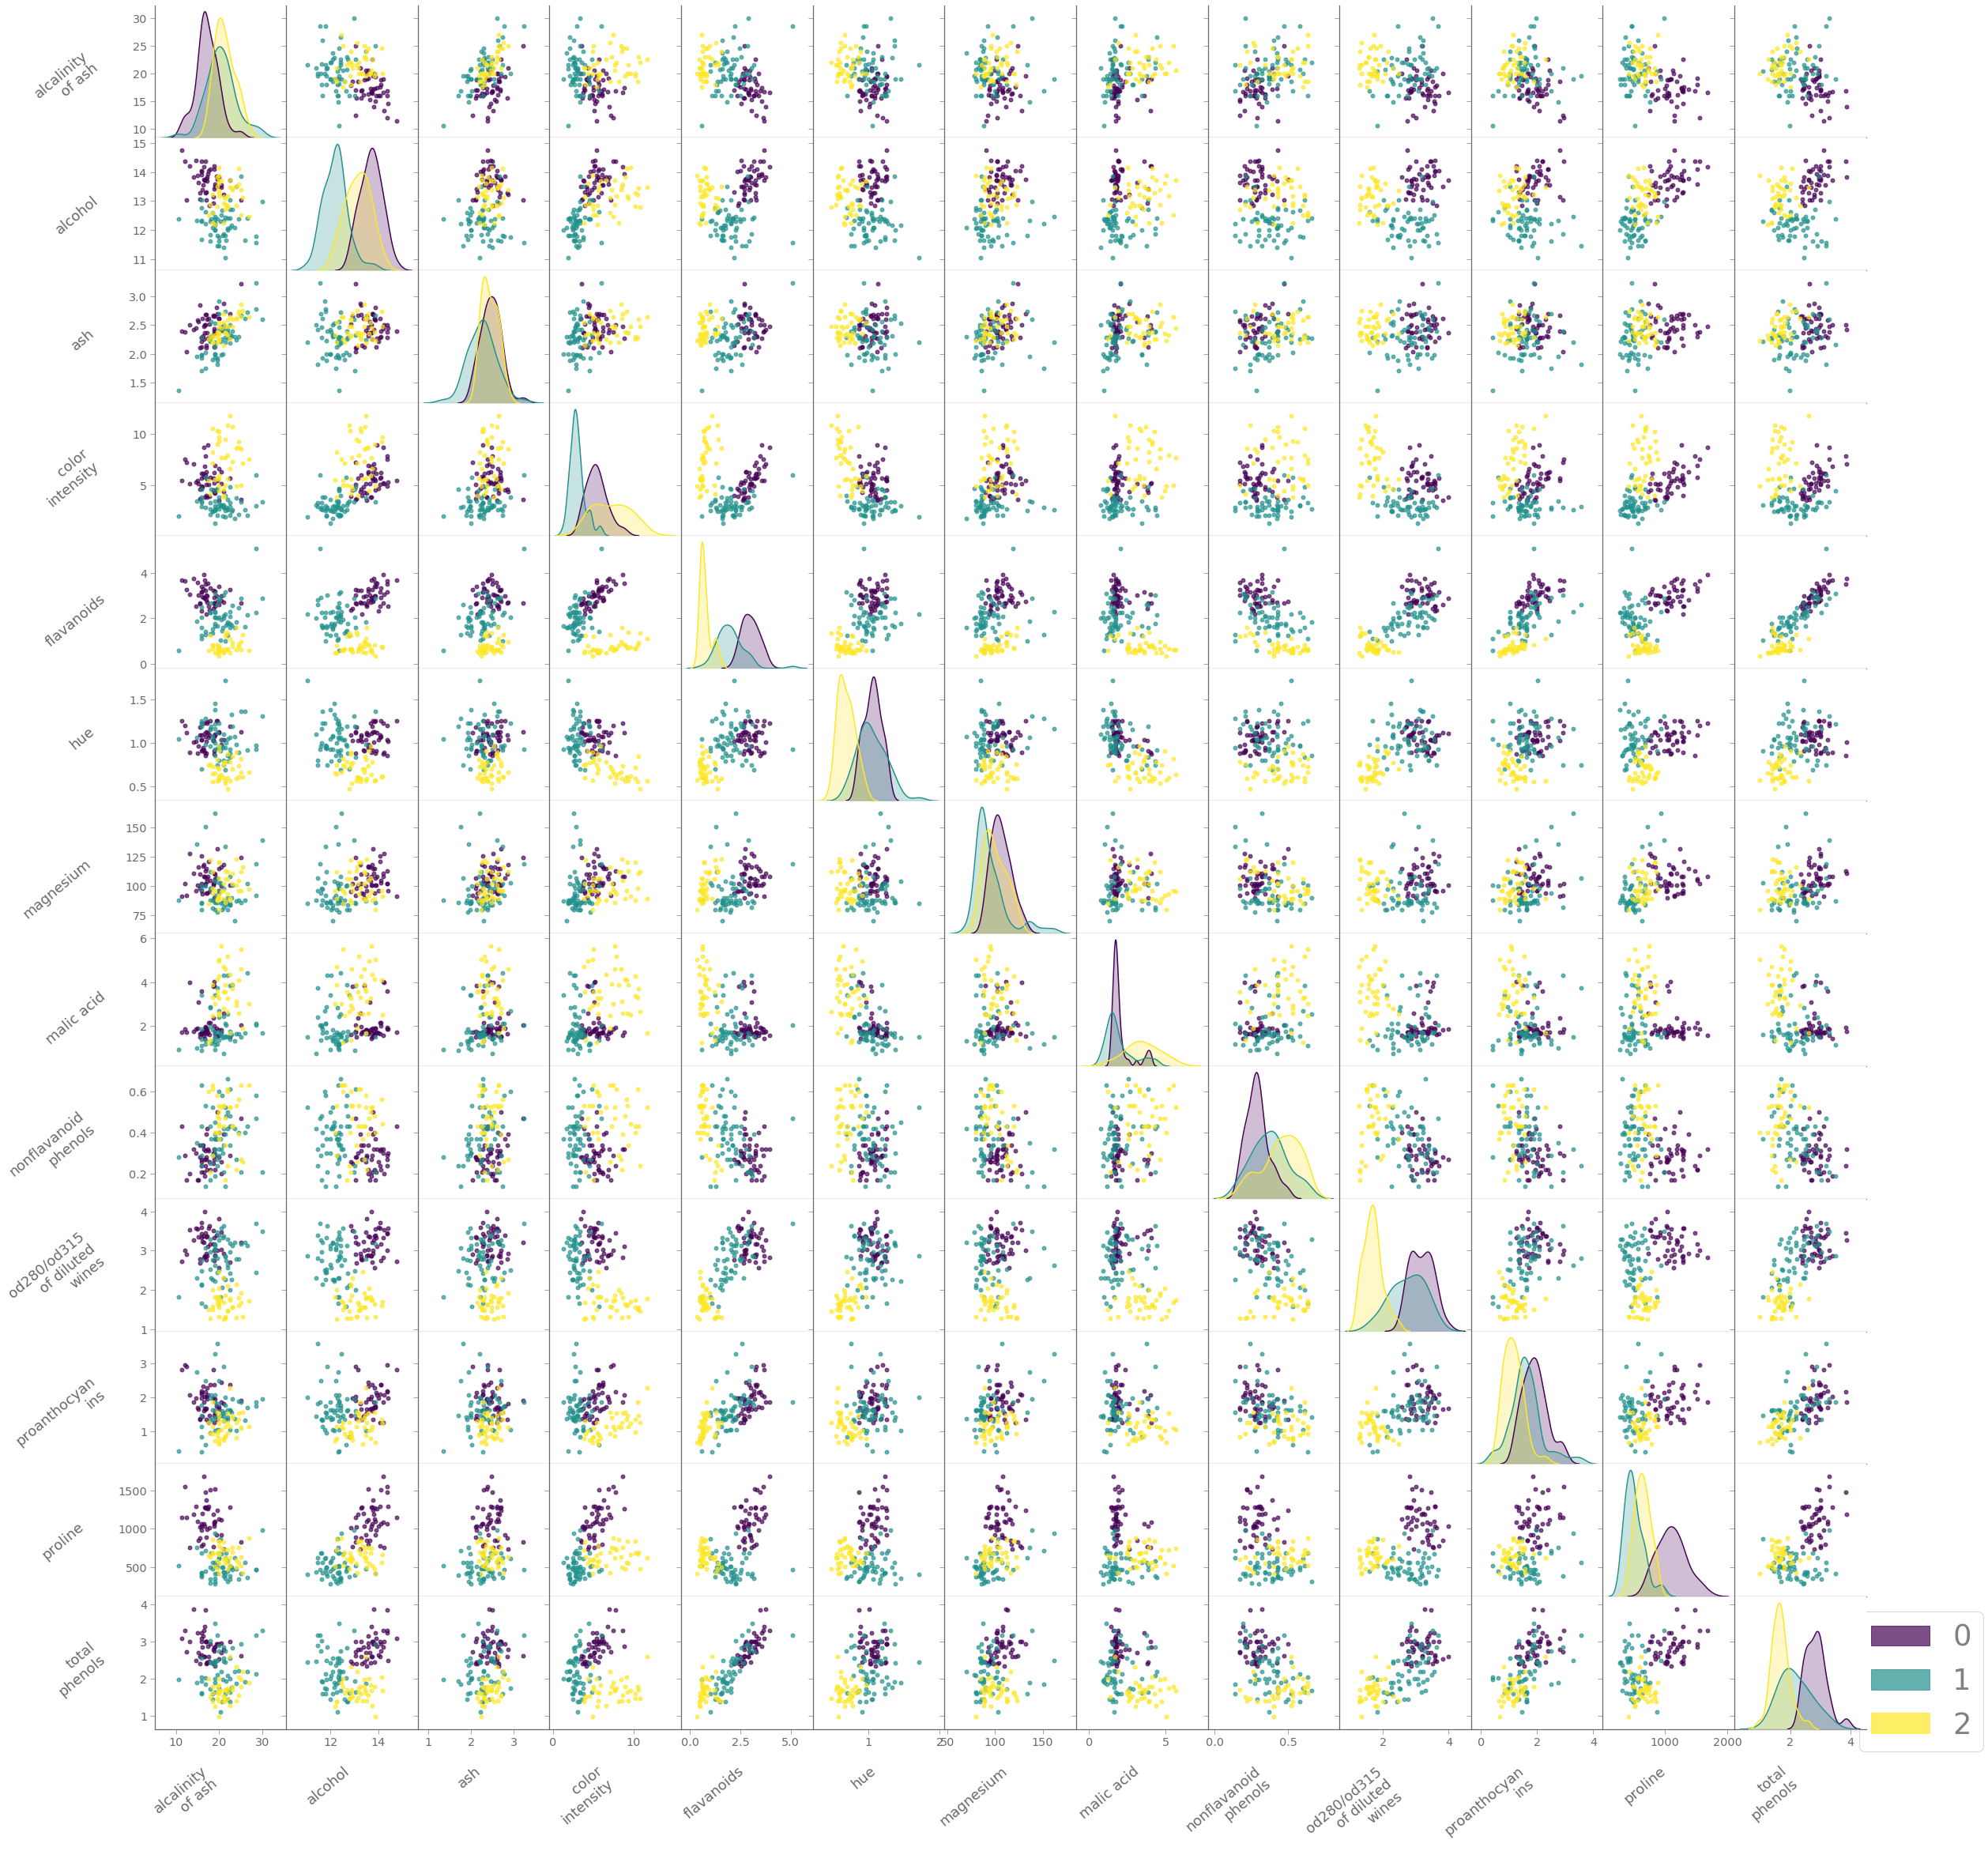

In [13]:
# pair plot
p = PrettierPlot(chart_scale=12)
p.pair_plot(
    df=train.data.dropna(),
    diag_kind="kde",
    target=train.target,
    columns=train.data.mlm_dtypes['continuous'][:15],
    bbox=(2.0, 0.0),
)

## Faceting

<a id = 'Faceting'></a>

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [14]:
# null score
pd.Series(train.target).value_counts(normalize=True)

1   0.401408
0   0.330986
2   0.267606
Name: Class label, dtype: float64

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data

No missing data


<a id = 'Missing-data'></a>

##### Training

In [15]:
# evaluate missing data
train.eda_missing_summary()

No nulls


##### Validation

In [16]:
# evaluate missing data
valid.eda_missing_summary()

No nulls


##### Impute

## Feature engineering

<a id = 'Feature-engineering'></a>

### Handcrafted

<a id = 'Handcrafted'></a>

### Polynomial features

<a id = 'Polynomial-features'></a>

In [17]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

In [19]:
# encode pipeline
encode_pipe = PandasFeatureUnion([
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
#     ("diff", make_pipeline(
#         DataFrameSelector(exclude_columns=train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
#     )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

In [20]:
train.data

alcalinity_of_ash*alcohol_binned_5 alcalinity_of_ash*ash_binned_5  \
168                           4.000000                       4.000000   
2                             2.000000                       3.000000   
153                           2.000000                       1.000000   
129                           3.000000                       3.000000   
133                           3.000000                       3.000000   
22                            1.000000                       1.000000   
122                           4.000000                       4.000000   
29                            1.000000                       0.000000   
104                           2.000000                       1.000000   
67                            2.000000                       0.000000   
107                           4.000000                       3.000000   
3                             2.000000                       1.000000   
162                           4.000000                       4.000000   
102                           2.000000                       3.000000   
36                            0.000000                       2.000000   
55                            3.000000                       3.000000   
28                            3.000000                       4.000000   
108                           1.000000                       0.000000   
165                           4.000000                       3.000000   
63                            1.000000                       1.000000   
130                           1.000000                       1.000000   
150                           4.000000                       4.000000   
86                            3.000000                       3.000000   
176                           2.000000                       2.000000   
175                           3.000000                       2.000000   
124                           2.000000                       3.000000   
77                            0.000000                       1.000000   
47                            0.000000                       0.000000   
112                           1.000000                       4.000000   
78                            0.000000                       0.000000   
146                           3.000000                       2.000000   
177                           4.000000                       4.000000   
46                            1.000000                       0.000000   
90                            1.000000                       1.000000   
143                           3.000000                       2.000000   
94                            0.000000                       1.000000   
52                            0.000000                       0.000000   
70                            2.000000                       2.000000   
169                           4.000000                       4.000000   
156                           3.000000                       2.000000   
75                            0.000000                       0.000000   
103                           1.000000                       0.000000   
31                            2.000000                       2.000000   
38                            0.000000                       0.000000   
40                            0.000000                       0.000000   
173                           3.000000                       3.000000   
87                            4.000000                       4.000000   
137                           4.000000                       4.000000   
27                            1.000000                       0.000000   
97                            0.000000                       0.000000   
106                           1.000000                       1.000000   
135                           1.000000                       1.000000   
42                            0.000000                       1.000000   
101                           1.000000                       0

## Feature transformation

<a id = 'Transformation'></a>

### Skew correction

<a id = 'Skew-correction'></a>

In [ ]:
# evaluate skew of number features - training data
train.skew_summary()

In [ ]:
# evaluate skew of number features - validation data
valid.skew_summary()

In [ ]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

# train.data = skew_pipe.fit_transform(train.data)
# valid.data = skew_pipe.transform(valid.data)

# train.update_dtypes()
# valid.update_dtypes()

### Scaling

<a id = 'Scaling'></a>

In [ ]:
#
scale_pipe = PandasFeatureUnion([
    ("scale", make_pipeline(
        DataFrameSelector(),
        PandasTransformer(RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Outliers


<a id = 'Outliers'></a>

In [ ]:
# identify outliers using IQR
train_pipe = Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=5,
                iqr_step=1.5,
                features=train.data.mlm_dtypes["continuous"],
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(iqr_outliers)

In [ ]:
# identify outliers using Isolation Forest
clf = IsolationForest(
    behaviour="new", max_samples=train.data.shape[0], random_state=0, contamination=0.01
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

In [ ]:
# identify outliers using extended isolation forest
train_pipe = Pipeline([
    ("outlier",train.ExtendedIsoForest(
                columns=train.data.mlm_dtypes["continuous"],
                n_trees=100,
                sample_size=int(np.ceil(train.data.shape[0] * .25)),
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(eif_outliers)

In [ ]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

In [ ]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["count"] >= 3]

In [ ]:
# remove outlers from predictors and response
outliers = np.array([59,121])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

## Additional exploratory data analysis

<a id = 'Additional-exploratory-data-analysis'></a>

In [23]:
train.data.columns

Index(['alcalinity_of_ash*alcohol_binned_5', 'alcalinity_of_ash*ash_binned_5',
       'alcalinity_of_ash*color_intensity_binned_5',
       'alcalinity_of_ash*flavanoids_binned_5',
       'alcalinity_of_ash*hue_binned_5',
       'alcalinity_of_ash*magnesium_binned_5',
       'alcalinity_of_ash*malic_acid_binned_5',
       'alcalinity_of_ash*nonflavanoid_phenols_binned_5',
       'alcalinity_of_ash*od280/od315_of_diluted_wines_binned_5',
       'alcalinity_of_ash*proanthocyanins_binned_5',
       ...
       'od280/od315_of_diluted_wines_binned_5',
       'proanthocyanins*proline_binned_5',
       'proanthocyanins*total_phenols_binned_5', 'proanthocyanins^2_binned_5',
       'proanthocyanins_binned_5', 'proline*total_phenols_binned_5',
       'proline^2_binned_5', 'proline_binned_5', 'total_phenols^2_binned_5',
       'total_phenols_binned_5'],
      dtype='object', length=104)

Feature summary Feature vs. target summary Target proportion 
 
 
 alcalinity_of_ash_binned_5 
 Count 
 Proportion 
 
 
 
 
 3 
 39 
 27.464789 
 
 
 1 
 29 
 20.422535 
 
 
 4 
 29 
 20.422535 
 
 
 0 
 27 
 19.014085 
 
 
 2 
 18 
 12.676056 
 
 
 
 
 
 alcalinity_of_ash_binned_5 
 0 
 1 
 2 
 
 
 
 
 0 
 20 
 7 
 0 
 
 
 1 
 16 
 8 
 5 
 
 
 2 
 4 
 10 
 4 
 
 
 3 
 5 
 17 
 17 
 
 
 4 
 2 
 15 
 12 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 3 
 4 
 
 
 
 
 0 
 74.074074 
 55.172414 
 22.222222 
 12.820513 
 6.896552 
 
 
 1 
 25.925926 
 27.586207 
 55.555556 
 43.589744 
 51.724138 
 
 
 2 
 0.000000 
 17.241379 
 22.222222 
 43.589744 
 41.379310

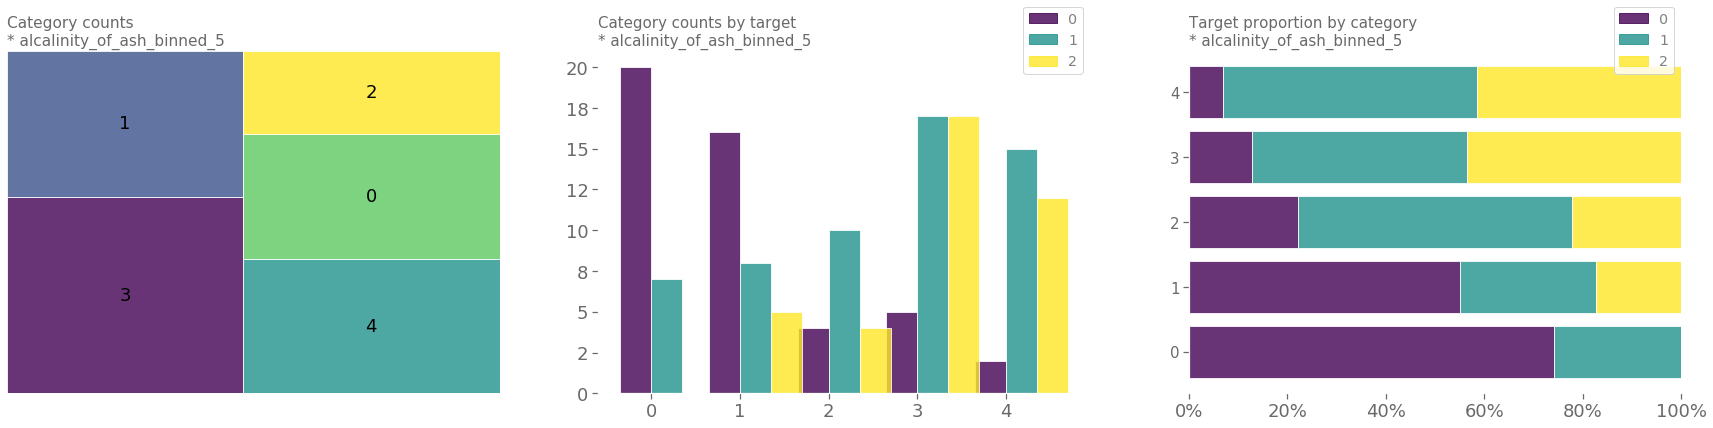

In [24]:
train.eda_cat_target_cat_feat(
    feature="alcalinity_of_ash_binned_5",
)

In [ ]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_scale=10)
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data,
    target=train.target,
    thresh=0.7,
    annot=True,
    ax=ax,
)

# Feature importance

<a id = 'Feature-importance'></a>

In [ ]:
# generate feature importance summary
estimators = [
    LGBMClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    XGBClassifier,
]

fs = train.FeatureSelector(
    data=train.data,
    target=train.target,
    estimators=estimators,
)
feature_selector_summary = fs.feature_selector_suite(
    rank=True,
    n_jobs=5,
    save_to_csv=True,
)

In [ ]:
# calculate cross-validation performance
estimators = [
    SVC,
    LGBMClassifier,
    LogisticRegression,
    XGBClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    #AdaBoostClassifier,
    ExtraTreesClassifier,
    KNeighborsClassifier,
]

# cv_summary = fs.feature_selector_cross_val(
# #     feature_selector_summary=feature_selector_summary,
#     feature_selector_summary=pd.read_csv("feature_selection_summary_2002020427.csv", index_col=0),
#     scoring=["accuracy"],
#     estimators=estimators,
#     n_folds=5,
#     n_jobs=5,
#     step=1,
#     save_to_csv=True,
#     verbose=True,
# )

###### Accuracy

In [ ]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
#     cv_summary=cv_summary,
#     feature_selector_summary=feature_selector_summary,
    cv_summary= pd.read_csv("cv_summary_2002010707.csv", index_col=0),
    feature_selector_summary=pd.read_csv("feature_selection_summary_2002020427.csv", index_col=0),
    scoring="accuracy",
    title_scale=0.8,
    marker_on=False,
)

In [ ]:
cross_val_features_df = fs.create_cross_val_features_df(
    scoring="accuracy",
#     cv_summary=cv_summary,
#     feature_selector_summary=feature_selector_summary,
    cv_summary= pd.read_csv("cv_summary_2002010707.csv", index_col=0),
    feature_selector_summary=pd.read_csv("feature_selection_summary_2002020427.csv", index_col=0),
)

In [ ]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    cross_val_features_df=cross_val_features_df
)

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [ ]:
#################################################################################
# import data
dataset = load_wine()
dataset = pd.merge(pd.DataFrame(dataset.data, columns=dataset.feature_names), pd.Series(dataset.target, name="Class label"), left_index=True, right_index=True)

# create training and validation datasets
df_train, df_valid = mlm.train_test_df_compile(data=dataset, target_col='Class label')

# load training data object
train = mlm.Machine(
    data=df_train,
    identify_as_continuous=['magnesium', 'proline'],
    target="Class label",
    target_type="category",
)

# load valid data object
valid = mlm.Machine(
    data=df_valid,
    identify_as_continuous=['magnesium', 'proline'],
    target="Class label",
)

#################################################################################
# feature transformation pipeline
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

# train.data = skew_pipe.fit_transform(train.data)
# valid.data = skew_pipe.transform(valid.data)

# train.update_dtypes()
# valid.update_dtypes()

#
scale_pipe = PandasFeatureUnion([
    ("scale", make_pipeline(
        DataFrameSelector(),
        PandasTransformer(RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()


#################################################################################
# remove outliers
outliers = np.array([59,121])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

print("completed")

## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# model/parameter space
all_space = {
    "LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None, "balanced"]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.5),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
#     "LogisticRegression": {
#         "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
#         "penalty": hp.choice("penalty", ["l1", "l2"]),
#     },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "subsample": hp.uniform("subsample", 0.3, 1),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "algorithm": hp.choice("algorithm", ["SAMME", "SAMME.R"]),
    },
    "ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
    },
    "SVC": {
        "C": hp.uniform("C", 0.001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovo", "ovr"]),
        "gamma": hp.uniform("gamma", 0.000000001, 5),
    },
    "KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=train.data,
    target=train.target,
    columns=cross_val_feature_dict,
    scoring="accuracy",
    n_folds=5,
    n_jobs=5,
    iters=1500,
    show_progressbar=True,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
analysis = "wine"
rundate = '20190808'
bayes_optim_summary = pd.read_csv("{}_hyperopt_{}.csv".format(rundate, analysis), na_values="nan")
bayes_optim_summary[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary, estimator=estimator)

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary['estimator']):
    train.modelParamPlot(bayes_optim_summary = bayes_optim_summary,
                         estimator=estimator,
                         all_space=all_space,
                         n_iter=100,
                         chart_scale=15)

In [ ]:
sample_space = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.sample_plot(sample_space, 1000)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

In [ ]:
# classification panel, single model
estimator = "SVC"; model_iter = 66
# estimator = 'GradientBoostingClassifier'; model_iter = 590
# estimator = 'XGBClassifier'; model_iter = 380

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

train.binary_classification_panel(
    model=model, X_train=train.data, y_train=train.target, labels=[0, 1], n_folds=4
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model, X_train=train.data, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Validation set evaluation - standard models

<a id = 'Validation-set-evaluation-standard-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "LGBMClassifier"; model_iter = 476
estimator = "XGBClassifier"; model_iter = 418
# estimator = "RandomForestClassifier"; model_iter = 382
# estimator = "GradientBoostingClassifier"; model_iter = 238
# estimator = "SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

# classification panel for validation data
train.binary_classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    X_valid=valid.data,
    y_valid=valid.target,
    labels=[0, 1],
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model,
            X_train=train.data,
            y_train=train.target,
            X_valid=valid.data,
            y_valid=valid.target,
            labels=[0, 1],
        )

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
estimator = "ExtraTreesClassifier"; model_iter = 145

modelE = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

modelE.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(modelR.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=feature_names)

##### Partial plots

In [ ]:
for feature in feature_names:
    pdpFeature = pdp.pdp_isolate(
        model=modelR.model, dataset=train.data, model_features=feature_names, feature=feature
    )

    pdp.pdp_plot(pdpFeature, feature)
    plt.rcParams["axes.facecolor"] = "white"
    plt.rcParams["figure.facecolor"] = "white"

    plt.grid(b=None)
    plt.show()

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
for i in np.arange(0, 4):
    train.single_shap_viz_tree(obsIx=i, model=modelR, data=train.data)

###### Force plots - multiple observations

In [ ]:
visual = train.multi_shap_viz_tree(obs_ixs=np.arange(0, 800), model=modelR, data=train.data)
visual

###### Dependence plots

In [ ]:
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=np.arange(0, 800), model=modelR, data=train.data
)
train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Fare",
    color_feature="Age",
    feature_names=train.data.columns.tolist(),
)

In [ ]:
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=np.arange(0, 800), model=modelL, data=train.data
)
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

# generate force plot
for top_ix in top_shap:
    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
    )

###### Summary plots

In [ ]:
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=np.arange(0, 800), model=modelG, data=train.data
)
feature_names = train.data.columns.tolist()
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=feature_names,
    )

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
all_space = {
    "LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    results_dir="{}_hyperopt_meta_{}.csv".format(rundate, analysis),
    X=oof_train,
    y=train.target,
    scoring="accuracy",
    n_folds=8,
    n_jobs=10,
    iters=1000,
    verbose=0,
)

In [ ]:
# read scores summary table
analysis = "wine"
rundate = "20190807"
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary_meta,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_scale=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary_meta, num_models=1
)
top_models

In [ ]:
# best second level learning model
estimator = "LGBMClassifier"; model_iter = 668
# estimator = "XGBClassifier"; model_iter = 380
# estimator = "RandomForestClassifier"; model_iter = 411
# estimator = "GradientBoostingClassifier"; model_iter = 590
# estimator = "SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)
train.binary_classification_panel(
    model=model, X_train=oof_train, y_train=train.target, labels=[0, 1]
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Validation set evaluation - stacked models

<a id = 'Validation-set-evaluation-stacked-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
estimator = "LGBMClassifier"; model_iter = 668
# estimator = "XGBClassifier"; model_iter = 380
# estimator = "RandomForestClassifier"; model_iter = 411
# estimator = "GradientBoostingClassifier"; model_iter = 590
# estimator = "SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)
model.fit(oof_train, train.target.values)

# fit model and make predictions
y_pred = model.predict(oof_valid)

In [ ]:
train.binary_classification_panel(
    model=model,
    X_train=oof_train,
    y_train=train.target,
    X_valid=oof_valid,
    y_valid=valid.target,
    labels=[0, 1],
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model,
            X_train=oof_train,
            y_train=train.target,
            X_valid=oof_valid,
            y_valid=valid.target,
            labels=[0, 1],
        )